# 2章 PyMCについてもう少し

## 2.1はじめに
    
hoge は親変数 λ が確定しても変数の値は依然としてランダムである。これをstochastic変数という。random()メソッドを呼ぶと新たに値がサンプリングされる。

hoge_plus_1 は親変数 hoge が確定すると値がその場で確定する。これをdeterministic変数という。

In [1]:
import pymc as pm
import numpy as np

In [2]:
hoge=pm.Exponential("hoge",1)
hoge_plus_1=hoge+1

In [3]:
print("hoge.value = ",hoge.value)
print("hoge_plus_1.value = ",hoge_plus_1.value,"\n")
hoge.random()
print("After Calling .Random()  \n")
print("hoge.value = ",hoge.value)
print("hoge_plus_1.value = ",hoge_plus_1.value)

hoge.value =  0.21546839338890156
hoge_plus_1.value =  1.21546839339 

After Calling .Random()  

hoge.value =  0.5563901523014116
hoge_plus_1.value =  1.5563901523


deterministic変数を生成するには

    @pm.deterministic
        def some_deterministic_var(v1=v1,):
            ...

こうすると明示的に生成できる。(キーワード引数じゃないとだめ)

またhoge_plus_1のように四則演算を行うと暗黙にdeterministic変数になる。

In [4]:
sigma=1
@pm.deterministic
def var(sigma = sigma):
    return sigma**2
print(type(var))
print(type(hoge_plus_1))


<class 'pymc.PyMCObjects.Deterministic'>
<class 'pymc.PyMCObjects.Deterministic'>


ここまでで事前分布の指定ができるようになった。次に観測データを組み込む。observed引数をTrueにすることによって組み込む事ができる。random()メソッドを呼んでも固定値なので変わらない。



In [5]:
fixed_var=pm.Poisson("fixed_var",1,value=np.array([10,15,20,25,30]),observed=True)
print("fixed_var.value = ",fixed_var.value,"\n")
fixed_var.random()
print("After Calling .Random()  ")
print("fixed_var.value = ",fixed_var.value)

fixed_var.value =  [10 15 20 25 30] 

After Calling .Random()  
fixed_var.value =  [10 15 20 25 30]


## 2.2 モデリングのアプローチ

以前のメッセージ受信数データを扱う。観測されたデータをどのように生成されたかを考える。



(0, 74)

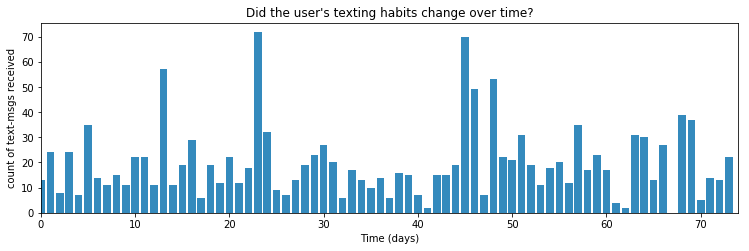

In [6]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)

1. 計数のデータはポアソン分布が良いのでは？
1. ある日を境にメッセージの振る舞いが変わっていそうだから、$\lambda$は2つ必要そうだ。まだ変化の日を$\tau$としよう。
1. ポアソン分布にはパラメータ$\lambda$が必要だがわからない。正である必要があるから指数分布がいいだろう。指数分布にもパラメータ$\alpha$がある。
1. $\alpha$も分からない。しかし特に信念があるわけではないから定数でいいだろう。$\alpha$にちょうどいい値はあるだろうか。$\alpha$に対して$\lambda$の平均値が観測データの平均となるようにとるとちょうど良さそうだ。
1. $\tau$については何日目なのか見当がつかないので一様分布でいいだろう。

以下にこの考え方のグラフィカルモデルを書く。
<img src="http://i.imgur.com/7J30oCG.png" width = 700/>

これをpymcで記述する。

$\tau$日を離散一様分布でサンプリングする。

In [7]:
tau=pm.rdiscrete_uniform(0,80)
print(tau)

18


指数分布$Exp(\alpha)$から$\lambda_1$と$\lambda_2$をサンプリングする。

ここで指数分布は$f_Z(z | \lambda) = \lambda e^{-\lambda z }, \;\; z\ge 0$であるから指数分布の期待値は$E[\; Z \;|\; \lambda \;] = \frac{1}{\lambda}$となる。またポアソン分布$P(Z = k) =\frac{ \lambda^k e^{-\lambda} }{k!}, \; \; k=0,1,2, \dots, \; \; \lambda \in \mathbb{R}_{>0} $の期待値は$E[ \;Z\; | \; \lambda \;] = \lambda $となる。よってデータの平均をとって逆数を取ればαがもとまる。

In [8]:
alpha=1/count_data.mean()
print(alpha)
lambda_1,lambda_2=pm.rexponential(alpha,2)

0.0506502395619


上記のようにlambda_1,lambda_2が定めたら、それを用いて日にちごとの$\lambda$の配列
lambdaが作られる。

In [9]:
lambda_=np.r_[lambda_1*np.ones(tau),lambda_2*np.ones(80-tau)]
print(lambda_)

[ 21.748675    21.748675    21.748675    21.748675    21.748675    21.748675
  21.748675    21.748675    21.748675    21.748675    21.748675    21.748675
  21.748675    21.748675    21.748675    21.748675    21.748675    21.748675
   5.73471551   5.73471551   5.73471551   5.73471551   5.73471551
   5.73471551   5.73471551   5.73471551   5.73471551   5.73471551
   5.73471551   5.73471551   5.73471551   5.73471551   5.73471551
   5.73471551   5.73471551   5.73471551   5.73471551   5.73471551
   5.73471551   5.73471551   5.73471551   5.73471551   5.73471551
   5.73471551   5.73471551   5.73471551   5.73471551   5.73471551
   5.73471551   5.73471551   5.73471551   5.73471551   5.73471551
   5.73471551   5.73471551   5.73471551   5.73471551   5.73471551
   5.73471551   5.73471551   5.73471551   5.73471551   5.73471551
   5.73471551   5.73471551   5.73471551   5.73471551   5.73471551
   5.73471551   5.73471551   5.73471551   5.73471551   5.73471551
   5.73471551   5.73471551   5.73471551   5

この$\lambda$によって以下のデータを人工的に作成できる。

In [10]:
data=pm.rpoisson(lambda_)
print(data)

[20 21 27 13 19 16 16 20 29 20 19 26 29 22 17 25 18 18  4 11  4  9  6 12  6
  5 10  4  7  8  5  6  3  5  9  4  5  5  5  8  5  5  4  1  7  6  9  5  4  4
  7  5  1  2  2  5  2  5  8  1  6  6  4  3  7  6  9  7  8  5 12  7  8  9  2
  4  5  6  5  5]


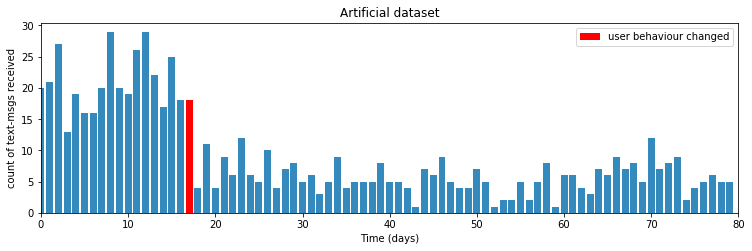

In [11]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau - 1, data[tau - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

以下にいくつかのデータを生成して見たものを示す。

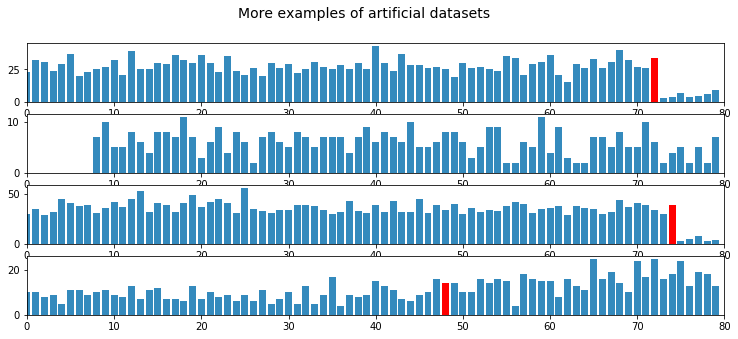

In [12]:
def plot_artificial_sms_dataset():
    tau = pm.rdiscrete_uniform(0, 80)
    alpha = 1. / 20.
    lambda_1, lambda_2 = pm.rexponential(alpha, 2)
    data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau - 1], color="r", label="user behaviour changed")
    plt.xlim(0, 80)

figsize(12.5, 5)
plt.suptitle("More examples of artificial datasets", fontsize=14)
for i in range(1, 5):
    plt.subplot(4, 1, i)
    plot_artificial_sms_dataset()

## 例題：ベイズ的A/Bテスト

A/Bテストとは、2つの異なる処置の効果の差を決定する統計処理ツールのこと。例えば製薬会社が薬Aと薬Bの効果の違いを知りたいとする。その時患者グループを２つに分割し、一方に薬Aを、もう一方に薬Bを処方する。この試験を繰り返し、統計学者がその効果を測定する。同じような例にどちらのウェブサイトのコンバージョン(登録、購入等のアクション)が良いかがあげられる。この際グループ間での差を一つだけに絞り込む。


実験後の分析としてp値等を用いた仮設検定を行う事が多いが、ここではベイズ的アプローチを学ぶ。後者の例であるウェブサイトについて考える。サイトAをみてユーザーが最終的にコンバージョンに繋がる確率を$p_A$と仮定する。この確率は実際には解らないがサイトAの有効性を示す。

N人のうちn人がコンバージョンにつながったとしても$n/N$が$p_A$と等しいとは限らない。(例えばサイコロを投げて1がでる真の確率は1/6だが6回投げても1回も出ないことも多々ある。)ベイズ統計を使えば適切ば事前分布と観測データを元にして真の妥当な確率を推論する事ができる。今回の例では$N$(全訪問者数)と$n$(コンバージョン数)からコンバージョンの真の頻度を推定することになる。

$p_A$の値に対して私たちは特に確信がないので$[0,1]$の一様分布でいいだろう。

In [13]:
p = pm.Uniform('p', lower = 0,  upper=1)
print(p.value)

0.2690516118616135


人口データのシミュレーションを行う。$p_A=0.05$として$N=1500$ユーザーがサイトAを見せられたと仮定する。$N$回の試行をシミュレートするためにベルヌーイ分布を用いる。もちろん実際には$p_A$の値は知らないがここでは知っているものとしてシミュレートする。

In [14]:
p_true = 0.05  
N = 1500

occurrences = pm.rbernoulli(p_true, N) #Ber(0.05)からN個の値をサンプリング
print(occurrences)  
print(occurrences.mean())

[False  True False ..., False False False]
0.046


観測データをPyMCのobs変数に設定して推論アルゴリズムを実行する。

In [15]:
obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)
mcmc = pm.MCMC([p, obs])
mcmc.sample(18000, 1000)

 [-----------------100%-----------------] 18000 of 18000 complete in 0.7 sec

未知数$p_A$の事後分布のプロットを示す。得られた事後分布は$p_A$の真の値はここだろう！という値が大きくなっている

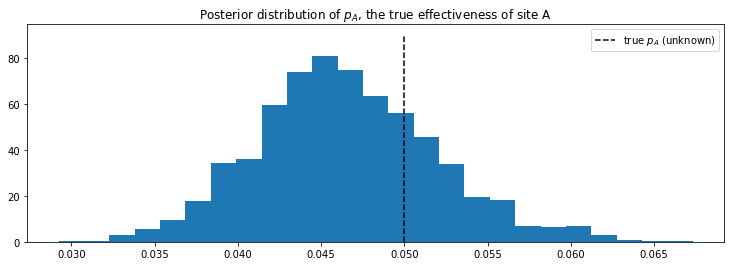

In [16]:
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=25, histtype="stepfilled", normed=True)
plt.legend();

サイトBについても同じように分析すれば$p_B$の事後確率を求める事ができる。実際に知りたいのは$delta=p_A - p_B$なのでこの三つをまとめて推論しよう。$p_B=0.04$と仮定し、$N_B=750  (= N_A /2)$とする。同様にサイトBに関してもシミュレーションでデータを生成する。

In [17]:
import pymc as pm
figsize(12, 4)

# these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

# notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

# generate some observations
observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)
print(observations_A.mean())
print(observations_B.mean())

0.0506666666667
0.0493333333333


データの生成は終わったので$p_A$、$p_B$を推論する。

In [18]:
#[0,1]の一様分布
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)

#deltaは引き算なのでdeterministic変数になる。(デコレーターを使わずとも
#四則演算を使えば暗黙にadeterministicになる)

@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B
#observedをTrueにして先ほどのデータを使う。
obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 1.5 sec

3つの事後分布を以下に示す。サイトBについてはデータが少ないので$p_B$の裾野が広くなっている。$delta$の事後分布については大部分が$delta=0$よりも右にあるのでサイトAの方がコンバージョンが良いことを示す。

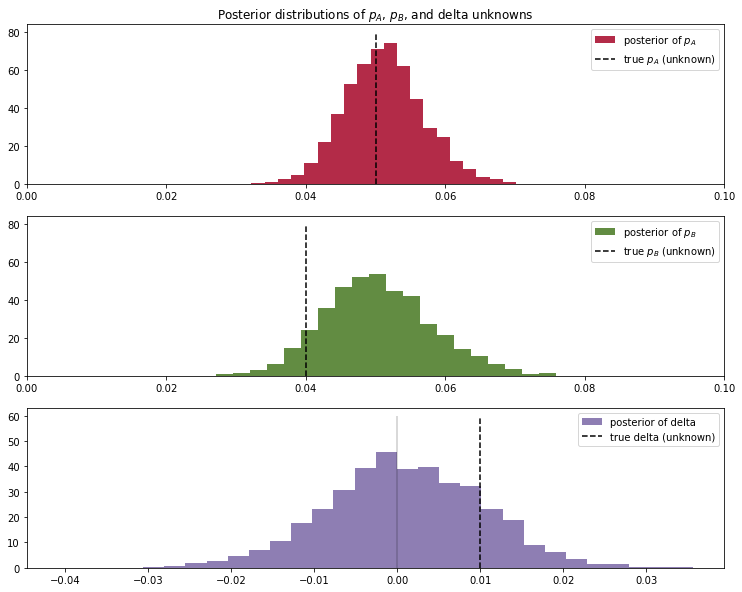

In [19]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

figsize(12.5, 10)
ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

$delta$が良くなっているという推論が間違っているかどうかの確率は以下でわかる。

In [20]:
print("Probability site A is WORSE than site B: %.3f" % \
    (delta_samples < 0).mean())

print("Probability site A is BETTER than site B: %.3f" % \
    (delta_samples > 0).mean())

Probability site A is WORSE than site B: 0.472
Probability site A is BETTER than site B: 0.528


 間違っている確率が高すぎる感があるが、サイトA,Bのデータをもっと増やせば推論の質が上がる。ここまでがA/Bテストのベイズ推論による方法である。仮設検定よりわかりやすい!!!(筆者曰く)